# HW1 Forward and Inverse Kinematics
Ting-Wei Hsu (twhsu3)

Do imports.

In [40]:
# Rigid body dynamics (pinocchio)
import pinocchio as pin

# Visualization (meshcat)
from pinocchio.visualize import MeshcatVisualizer
import meshcat_shapes

# Robot models (robot_descriptions)
from robot_descriptions.loaders.pinocchio import load_robot_description

# Math ("expm" is the matrix exponential function)
import numpy as np
from scipy.linalg import expm, logm

# Timing
import time

# Plots
import matplotlib.pyplot as plt

# Interaction
import ipywidgets as widgets
from IPython.display import display

# Suppress the display of very small numbers
np.set_printoptions(suppress=True)

Load a robot model and show how many joints there are.

In [3]:
# Load model
robot = load_robot_description(
    'ur10_description',           # name of robot model
    root_joint=None,                # fixed base
)

# Show number of joints
print(f'There are {robot.nq} joints.')

There are 6 joints.


Print a list of all frames.

In [4]:
print('FRAMES\n')
for frame in robot.model.frames:
    print(f' {frame.name}')
    

FRAMES

 universe
 world
 world_joint
 base_link
 base_link-base_fixed_joint
 base
 shoulder_pan_joint
 shoulder_link
 shoulder_lift_joint
 upper_arm_link
 elbow_joint
 forearm_link
 wrist_1_joint
 wrist_1_link
 wrist_2_joint
 wrist_2_link
 wrist_3_joint
 wrist_3_link
 ee_fixed_joint
 ee_link
 wrist_3_link-tool0_fixed_joint
 tool0


In [41]:
print('Joint Translations\n')

for i in range(1, robot.model.njoints):
    joint_name = robot.model.names[i]
    
    # Translation from Parent Joint -> This Joint
    translation = robot.model.jointPlacements[i].translation
    print(f"{translation}")
    
target_frames = ["ee_link"]

for frame in robot.model.frames:
    if frame.name in target_frames:
        # frame.placement is the transform from the Parent Joint (Wrist 3) -> This Frame
        translation = frame.placement.translation
        print(f"{translation}")


Joint Translations

[0.     0.     0.1273]
[0.       0.220941 0.      ]
[ 0.     -0.1719  0.612 ]
[0.     0.     0.5723]
[0.     0.1149 0.    ]
[0.     0.     0.1157]
[0.     0.0922 0.    ]


Display robot in browser.

In [42]:
# Create a visualizer
vis = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
robot.setVisualizer(vis, init=False)
vis.initViewer(open=True)
vis.loadViewerModel()

# Choose what to display
vis.displayFrames(False)
vis.displayVisuals(True)
vis.displayCollisions(False)

# Add our own frames to the visualizer because the default frames are hard to see
# - All frames
frames_to_show = [
    'base_link',
    'shoulder_link',
    'upper_arm_link',
    'forearm_link',
    'wrist_1_link',
    'wrist_2_link',
    'wrist_3_link',
    'ee_link',
]

for frame in frames_to_show:
    meshcat_shapes.frame(vis.viewer['frames/' + frame], opacity=1.0, axis_length=0.2)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


Put the robot at its "neutral" configuration.

In [43]:
# Get and show the neutral configuration (most likely all zeros)
q = pin.neutral(robot.model)
print(f'{q = }')

# Do forward kinematics
# - Compute the placement of all joint frames (modifies robot.data but not robot.model or q)
pin.forwardKinematics(robot.model, robot.data, q)
# - Compute the placement of all link frames (modifies robot.data but not robot.model)
pin.updateFramePlacements(robot.model, robot.data)

# Show the configuration in the visualizer
vis.display(q)
for frame in frames_to_show:
    frame_id = robot.model.getFrameId(frame)
    vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

q = array([0., 0., 0., 0., 0., 0.])


Create sliders that allow us to change the configuration.

In [11]:
# Callback function that receives all 7 slider values
def on_slider_change(change):
    q = np.deg2rad(np.array([slider.value for slider in sliders]))
    pin.forwardKinematics(robot.model, robot.data, q)
    pin.updateFramePlacements(robot.model, robot.data)
    vis.display(q)
    for frame in frames_to_show:
        frame_id = robot.model.getFrameId(frame)
        vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

# Create 7 sliders
sliders = []
for i in range(6):
    slider = widgets.FloatSlider(
        value=0,
        min=-180,
        max=180,
        step=0.1,
        description=f'Joint {i+1}:',
        continuous_update=True,  # Only update on release
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        layout=widgets.Layout(width='600px')  # Set slider width
    )
    # Attach the same callback to each slider
    slider.observe(on_slider_change, names='value')
    sliders.append(slider)

# Display all sliders
display(widgets.VBox(sliders))

# Initialize robot
on_slider_change(None)

Define a function to do forward kinematics by product of exponentials.

In [12]:
def to_skew(w):
    w_skew = np.zeros([3,3])
    w_skew[0,1] = -w[2]
    w_skew[1,0] = w[2]
    w_skew[0,2] = w[1]
    w_skew[2,0] = -w[1]
    w_skew[1,2] = -w[0]
    w_skew[2,1] = w[0]
    return w_skew

def hat(V):
    V_hat = np.zeros([4,4])
    V_hat[0:3, 0:3] = to_skew(V[0:3])
    V_hat[0:3,3] = V[3:6]
    return V_hat

def forward_kinematics_poe(theta):

    w = [[0., 0., 1.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 0., -1.],
         [0., 1., 0.]]
    
    q = [[0., 0., 0.1273],
         [0., 0.220941, 0.1273],
         [0.612, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273-0.1157]]
    
    M = [[0., 1., 0., 0.612+0.5723],
         [1., 0., 0., 0.220941-0.1719+0.1149+0.0922],
         [0., 0., -1., 0.1273-0.1157],
         [0., 0., 0., 1.]]

    T = M
    for w_i, q_i, theta_i in reversed(list(zip(w, q, theta))):
        S = np.concatenate((w_i, -to_skew(w_i) @ q_i))
        T = expm(hat(S) * theta_i) @ T

    return T

Define a function to print a homogeneous transformation matrix, rounding very small numbers to (positive) zero, so it is easy to compare two different matrices.

In [13]:
def show_homog(T, decimals=8, tol=1e-10):
    T = T.copy()
    T[np.abs(T) < tol] = 0.
    with np.printoptions(suppress=True):
        print(T)

Compare our forward kinematic solution to the one given by pinocchio.

In [14]:
# Sample a configuration at random
q = pin.randomConfiguration(robot.model)
 
# Do forward kinematics
# - Compute the placement of all joint frames (modifies robot.data but not robot.model or q)
pin.forwardKinematics(robot.model, robot.data, q)
# - Compute the placement of all link frames (modifies robot.data but not robot.model)
pin.updateFramePlacements(robot.model, robot.data)

# Show the configuration in the visualizer
vis.display(q)
for frame in frames_to_show:
    frame_id = robot.model.getFrameId(frame)
    vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

# Get pose of last link (pinocchio)
T_0_1_pin = robot.data.oMf[robot.model.getFrameId(frames_to_show[-1])].homogeneous

# Get pose of last link (by hand)
T_0_1_poe = forward_kinematics_poe(q)

# Print the two solutions
print('PINOCCHIO')
show_homog(T_0_1_pin)
print('')
print('OURS')
show_homog(T_0_1_poe)

# Check that the two solutions are the same
assert(np.allclose(T_0_1_pin, T_0_1_poe))

PINOCCHIO
[[-0.7104286   0.64114437  0.2902156  -0.9973043 ]
 [-0.08124406 -0.48433112  0.87110434  0.31071307]
 [ 0.69906409  0.59527914  0.39617186  0.51348964]
 [ 0.          0.          0.          1.        ]]

OURS
[[-0.7104286   0.64114437  0.2902156  -0.9973043 ]
 [-0.08124406 -0.48433112  0.87110434  0.31071307]
 [ 0.69906409  0.59527914  0.39617186  0.51348964]
 [ 0.          0.          0.          1.        ]]


Compare the computation time.

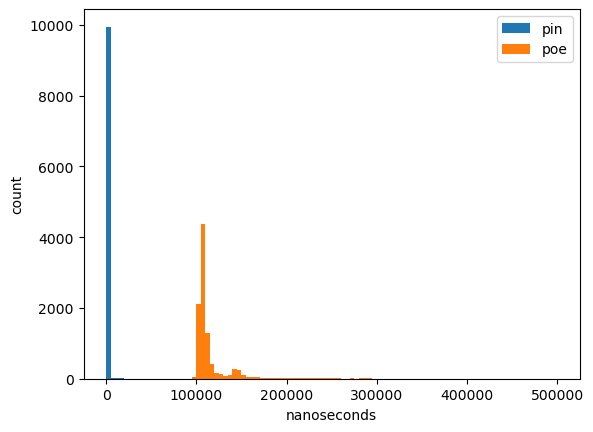

Mean computation times
 pin:      950 ns
 poe:   120214 ns


In [15]:
# Arrays in which to store computation times
t_pin = []
t_poe = []

# Number of iterations
n = 10000

# Iterate
for i in range(n):
    # Sample a configuration
    q = pin.randomConfiguration(robot.model)

    # Measure the time to do forward kinematics with pinocchio (in nanoseconds)
    start_time = time.perf_counter_ns()
    pin.framesForwardKinematics(robot.model, robot.data, q)
    end_time = time.perf_counter_ns()
    t_pin.append(end_time - start_time)

    # Measure the time to do forward kinematics by hand (in nanoseconds)
    start_time = time.perf_counter_ns()
    T = forward_kinematics_poe(q)
    end_time = time.perf_counter_ns()
    t_poe.append(end_time - start_time)

# Show histograms
plt.hist(t_pin, bins=np.linspace(0, 500000, 101), label='pin')
plt.hist(t_poe, bins=np.linspace(0, 500000, 101), label='poe')
plt.legend()
plt.xlabel('nanoseconds')
plt.ylabel('count')
plt.show()

# Print mean values
print(f'Mean computation times')
print(f' pin: {np.mean(t_pin):8.0f} ns')
print(f' poe: {np.mean(t_poe):8.0f} ns')

## Velocity kinematics

Define a function to compute the adjoint matrix

$$\textrm{Ad}_T = \begin{bmatrix} R & 0 \\ [p]_\times R & R \end{bmatrix}.$$

In [16]:
def adjoint(T):
    R = T[0:3, 0:3]
    p = T[0:3, 3]
    return np.block([[R, np.zeros((3, 3))],
                     [to_skew(p) @ R, R]])

def adjoint_inv(T):
    R = T[0:3, 0:3]
    p = T[0:3, 3]
    return np.block([[R.T, np.zeros((3, 3))],
                     [-R.T @ to_skew(p), R.T]])

Define other useful functions.

In [17]:
def from_skew(w_skew):
    return np.array([w_skew[2, 1], w_skew[0, 2], w_skew[1, 0]])

def vee(V_hat):
    return np.concatenate([from_skew(V_hat[0:3, 0:3]), V_hat[0:3, 3]])

Define a function to compute the space Jacobian.

In [18]:
def Jacobian_space(theta):
    
    # axis of each joint in space frame
    w = [[0., 0., 1.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 0., -1.],
         [0., 1., 0.]]
    
    # a point on the axis in space frame
    p = [[0., 0., 0.1273],
         [0., 0.220941, 0.1273],
         [0.612, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273-0.1157]]
    
    # Initialize space Jacobian as all zeros
    J_s = np.zeros((6, len(theta)))

    # Compute all the other columns of the space Jacobian
    for i in range(len(theta)):
        w_i = w[i]
        p_i = p[i]
        s_i = np.concatenate((w_i, -to_skew(w_i) @ p_i))
        
        theta_i = theta[i]
        
        if i == 0:
            J_s[:, i] = s_i
            e_train = expm(hat(s_i) * theta_i)
        else:
            J_s[:, i] = adjoint(e_train) @ s_i # e_train = e^1 @ e^2 @ ... @ e^(i-1)
            e_train = e_train @ expm(hat(s_i) * theta_i) 

    # Return the space Jacobian
    return J_s

def Jacobian_body(theta):
    
    # axis of each joint in space frame
    w = [[0., 0., 1.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 0., -1.],
         [0., 1., 0.]]
    
    # a point on the axis in space frame
    p = [[0., 0., 0.1273],
         [0., 0.220941, 0.1273],
         [0.612, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273-0.1157]]
    
    M = np.array([[0., 1., 0., 0.612+0.5723],
                    [1., 0., 0., 0.220941-0.1719+0.1149+0.0922],
                    [0., 0., -1., 0.1273-0.1157],
                    [0., 0., 0., 1.]])
    
    # Initialize space Jacobian as all zeros
    J_b = np.zeros((6, len(theta)))

    # Compute all the other columns of the space Jacobian
    for i in reversed(range(len(theta))):
        w_i = w[i]
        p_i = p[i]
        s_i = np.concatenate((w_i, -to_skew(w_i) @ p_i))
        b_i = adjoint_inv(M) @ s_i # convert the screw axis to the end-effector body frame
        
        theta_i = theta[i]

        if i == len(theta) - 1:
            J_b[:, i] = b_i
            e_train =  expm(-hat(b_i) * theta_i)
        else:
            J_b[:, i] = adjoint(e_train) @ b_i # e_train = e^i @ e^(i+1) @ ... @ e^n
            e_train =  e_train @ expm(-hat(b_i) * theta_i)
        
    # Return the space Jacobian
    return J_b

def Jacobian_body_2(theta):
    
    # axis of each joint in space frame
    w = [[0., 0., 1.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 0., -1.],
         [0., 1., 0.]]
    
    # a point on the axis in space frame
    p = [[0., 0., 0.1273],
         [0., 0.220941, 0.1273],
         [0.612, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273-0.1157]]
    
    # Initialize space Jacobian as all zeros
    J_b = np.zeros((6, len(theta)))

    M = np.array([[0., 1., 0., 0.612+0.5723],
                    [1., 0., 0., 0.220941-0.1719+0.1149+0.0922],
                    [0., 0., -1., 0.1273-0.1157],
                    [0., 0., 0., 1.]])

    e_train = np.array([[0., 1., 0., 0.612+0.5723],
                    [1., 0., 0., 0.220941-0.1719+0.1149+0.0922],
                    [0., 0., -1., 0.1273-0.1157],
                    [0., 0., 0., 1.]])

    # Compute all the other columns of the space Jacobian
    for i in reversed(range(len(theta))):
        w_i = w[i]
        p_i = p[i]
        s_i = np.concatenate((w_i, -to_skew(w_i) @ p_i))

        b_i = adjoint_inv(M) @ s_i
        print(i, b_i)
        
        theta_i = theta[i]
        
        e_train =  expm(hat(s_i) * theta_i) @ e_train
        J_b[:, i] = adjoint_inv(e_train) @ s_i # e_train = e^i @ e^(i+1) @ ... @ e^n @ M

    # Return the space Jacobian
    return J_b

Check that our space Jacobian matches what is computed by Pinocchio.

In [19]:
## Compare with Pinocchio
# - Do forward velocity kinematics
pin.computeJointJacobians(robot.model, robot.data)
# - Get the space jacobian <-- WARNING - Pinocchio assumes twists are (v, w) and not (w, v)
J_s_pin_vw = pin.getFrameJacobian(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.WORLD)
# - Reorder the space jacobian to be consistent with an assumption that twists are (w, v)
J_s_pin = np.vstack((J_s_pin_vw[3:, :], J_s_pin_vw[:3, :]))

# POE
J_s_poe = Jacobian_space(q) #TODO: q <- theta

# Print shape of each Jacobian
print(f'shape of J_s_pin: {J_s_pin.shape}')
print(f'shape of J_s_poe: {J_s_poe.shape}')

# Check if the two results are the same
print(J_s_pin)
print(J_s_poe)
assert(np.allclose(J_s_pin, J_s_poe))


shape of J_s_pin: (6, 6)
shape of J_s_poe: (6, 6)
[[ 0.          0.19152161  0.19152161  0.19152161  0.30054775  0.6233191 ]
 [ 0.          0.9814884   0.9814884   0.9814884  -0.05864704  0.76754254]
 [ 1.          0.          0.          0.          0.95196196 -0.14950498]
 [ 0.         -0.12494347  0.27442507  0.62714246 -0.04884904  0.40869957]
 [ 0.          0.0243807  -0.05354962 -0.12237672 -1.06520806 -0.18730006]
 [ 0.          0.          0.45713853  0.90253786 -0.05020141  0.74237982]]
[[ 0.          0.19152161  0.19152161  0.19152161  0.30054775  0.6233191 ]
 [ 0.          0.9814884   0.9814884   0.9814884  -0.05864704  0.76754254]
 [ 1.          0.          0.          0.          0.95196196 -0.14950498]
 [ 0.         -0.12494347  0.27442507  0.62714246 -0.04884904  0.40869957]
 [ 0.          0.0243807  -0.05354962 -0.12237672 -1.06520806 -0.18730006]
 [ 0.          0.          0.45713853  0.90253786 -0.05020141  0.74237982]]


In [20]:
## Compare with Pinocchio
pin.computeJointJacobians(robot.model, robot.data)
# - Get the space jacobian <-- WARNING - Pinocchio assumes twists are (v, w) and not (w, v)
J_b_pin_vw = pin.getFrameJacobian(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.ReferenceFrame.LOCAL)
# - Reorder the space jacobian to be consistent with an assumption that twists are (w, v)
J_b_pin = np.vstack((J_b_pin_vw[3:, :], J_b_pin_vw[:3, :]))

# POE
J_b_poe = Jacobian_body(q) #TODO: q <- theta
J_b_poe_2 = Jacobian_body_2(q) #TODO: q <- theta

# Check if the two results are the same
print(J_b_pin)
print(J_b_poe)
print(J_b_poe_2)
assert(np.allclose(J_b_pin, J_b_poe))
assert(np.allclose(J_b_pin, J_b_poe_2))


5 [1. 0. 0. 0. 0. 0.]
4 [0.     0.     1.     0.     0.0922 0.    ]
3 [ 1.      0.      0.      0.     -0.1157  0.    ]
2 [ 1.      0.      0.      0.     -0.1157  0.5723]
1 [ 1.      0.      0.      0.     -0.1157  1.1843]
0 [ 0.        0.       -1.        1.1843   -0.256141  0.      ]
[[-0.14950498  0.87271318  0.87271318  0.87271318  0.          1.        ]
 [-0.71202571  0.23112757  0.23112757  0.23112757 -0.88084983  0.        ]
 [ 0.68605222  0.43006018  0.43006018  0.43006018  0.47339579  0.        ]
 [ 0.74237982 -0.16472447 -0.04394975  0.05648859 -0.         -0.        ]
 [ 0.38874071  1.1425367   0.54725766 -0.0081486   0.04364709 -0.        ]
 [ 0.56523812 -0.27976205 -0.20492668 -0.11025194  0.08121435  0.        ]]
[[-0.14950498  0.87271318  0.87271318  0.87271318  0.          1.        ]
 [-0.71202571  0.23112757  0.23112757  0.23112757 -0.88084983  0.        ]
 [ 0.68605222  0.43006018  0.43006018  0.43006018  0.47339579  0.        ]
 [ 0.74237982 -0.16472447 -0.0439497

## Inverse kinematics (Jacobian transpose method)

Set up inverse kinematics problem.

In [58]:
# Choose a desired pose
T_0_D = np.array([[1., 0., 0., 0.3],
                  [0., 1., 0., 0.4],
                  [0., 0., 1., 0.5],
                  [0., 0., 0., 1.]])

# Show desired pose in the browser window
meshcat_shapes.frame(vis.viewer['frames/' + 'desired_pose'], opacity=1.0, axis_length=0.2)
vis.viewer['frames/' + 'desired_pose'].set_transform(T_0_D)


Choose an initial configuration at random.

In [66]:
q0 = pin.randomConfiguration(robot.model)

# Do forward kinematics
# - Compute the placement of all joint frames (modifies robot.data but not robot.model or q)
pin.forwardKinematics(robot.model, robot.data, q0)
# - Compute the placement of all link frames (modifies robot.data but not robot.model)
pin.updateFramePlacements(robot.model, robot.data)

# Show the configuration in the visualizer
vis.display(q0)
for frame in frames_to_show:
    frame_id = robot.model.getFrameId(frame)
    vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

Method 1: Gradient descent (i.e., the Jacobian transpose method)

In [70]:
def compute_gradient(q, B):
    pin.forwardKinematics(robot.model, robot.data, q)
    pin.updateFramePlacements(robot.model, robot.data)
    A = robot.data.oMf[robot.model.getFrameId(frames_to_show[-1])].homogeneous
    pin.computeJointJacobians(robot.model, robot.data)
    J_b = pin.getFrameJacobian(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.LOCAL)
    v_b_error = np.array(pin.log6(pin.SE3(np.linalg.inv(A) @ B)))
    Jlog6 = pin.Jlog6(pin.SE3(np.linalg.inv(B) @ A))

    cost = (1/2) * np.dot(v_b_error, v_b_error)
    
    return -J_b.T @ Jlog6.T @ v_b_error, cost

SUCCESS (in 503 iterations)


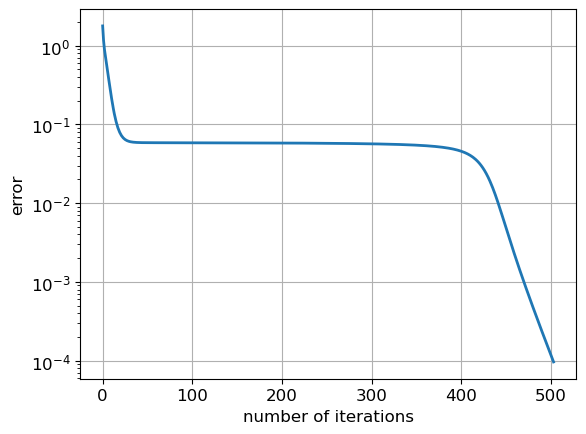

In [71]:
q = q0.copy()

# Max number of iterations
max_iters = 1e5

# Step size
alpha = 0.45

# Tolerance
e_tol = 1e-4

# Array to store errors
e = []

# Current number of iterations
num_iters = 0

while True:
    grad, cost = compute_gradient(q, T_0_D)

    # store current error
    e_cur = cost
    #print(f'Iteration {num_iters}, Error: {e_cur}')
    e.append(float(e_cur))

    # Check if stopping criterion is met
    if e_cur < e_tol:
        print(f'SUCCESS (in {num_iters} iterations)')
        break

    # Check if maximum number of iterations has been reached
    if num_iters > max_iters:
        print(f'FAILURE (exceeded {max_iters} iterations)')
        break
    
    # Do one step of gradient descent
    q -= alpha * grad

    # Increment number of iterations
    num_iters += 1

    # Do forward kinematics
    # - Compute the placement of all joint frames (modifies robot.data but not robot.model or q)
    pin.forwardKinematics(robot.model, robot.data, q)
    # - Compute the placement of all link frames (modifies robot.data but not robot.model)
    pin.updateFramePlacements(robot.model, robot.data)

    # Show the configuration in the visualizer
    vis.display(q)
    for frame in frames_to_show:
        frame_id = robot.model.getFrameId(frame)
        vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)
    vis.viewer['frames/' + 'desired_pose'].set_transform(T_0_D)

# Plot error over iterations
plt.plot(e, linewidth=2)
plt.yscale('log')
plt.xlabel('number of iterations', fontsize=12)
plt.ylabel('error', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()

Method 2: Damped least squares (i.e., Levenberg-Marquardt with a fixed constant)

In [72]:
def get_ik_residual_and_jacobian(q, B, use_correct_derivative=True):
    pin.forwardKinematics(robot.model, robot.data, q)
    pin.updateFramePlacements(robot.model, robot.data)
    A = robot.data.oMf[robot.model.getFrameId(frames_to_show[-1])].homogeneous
    pin.computeJointJacobians(robot.model, robot.data)
    J_b = pin.getFrameJacobian(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.LOCAL)
    v_b_error = np.array(pin.log6(pin.SE3(np.linalg.inv(A) @ B)))
    Jlog6 = pin.Jlog6(pin.SE3(np.linalg.inv(B) @ A))
    if use_correct_derivative:
        return v_b_error, -Jlog6 @ J_b
    else:
        return v_b_error, -J_b

SUCCESS (in 26 iterations)


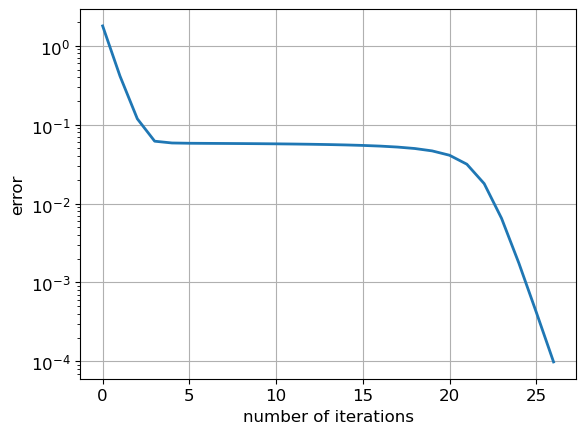

In [73]:
# Initial configuration
q = q0.copy()

gamma=0.1

e_tol=1e-4

# Max number of iterations
max_iters = 1e5

# Array to store errors
e = []

# Current number of iterations
num_iters = 0

while True:
    r, J = get_ik_residual_and_jacobian(q, T_0_D)
        
    # Get and store current error
    e_cur = (1 / 2) * np.dot(r, r)
    e.append(float(e_cur))

    # Check if stopping criterion is met
    if e_cur < e_tol:
        print(f'SUCCESS (in {num_iters} iterations)')
        break

    # Check if maximum number of iterations has been reached
    if num_iters > max_iters:
        print(f'FAILURE (exceeded {max_iters} iterations)')
        break
        
    # Do one step of LM
    dq = - np.linalg.inv(J.T @ J + gamma * np.identity(len(q))) @ J.T @ r
    q += dq

    # Increment number of iterations
    num_iters += 1

    # Update display
    pin.forwardKinematics(robot.model, robot.data, q)
    pin.updateFramePlacements(robot.model, robot.data)
    vis.display(q)
    for frame in frames_to_show:
        frame_id = robot.model.getFrameId(frame)
        vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)
    vis.viewer['frames/' + 'desired_pose'].set_transform(T_0_D)
    
# Plot error over iterations
plt.plot(e, linewidth=2)
plt.yscale('log')
plt.xlabel('number of iterations', fontsize=12)
plt.ylabel('error', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()